In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import numpy as np
import itertools

In [2]:
# # If the data is in sql format, use the following cell to extract the markers
# path = "path_to_sql_file"
# con = sqlite3.connect(path)
# join = pd.read_sql_query("SELECT CUPTI_ACTIVITY_KIND_MARKER.*, StringTable.value AS 'name_str' FROM CUPTI_ACTIVITY_KIND_MARKER JOIN StringTable ON CUPTI_ACTIVITY_KIND_MARKER.name == StringTable._id_;", con)

In [3]:
join = pd.read_parquet('data/pcm/nvprof_markers/markers_run_0_config_8_2_ib_nvprof_2_resnet50_dali-cpu-to-gpu_32_fp16_fp32_ret_0_0.gzip')

In [4]:
def select_nvtx_markers(df):    
    mask = (
        (df['name_str'] == 'End of Batch') | 
        (df['name_str'] == 'Forward Pass') | 
        (df['name_str'] == 'Backward Pass') | 
        (df['name_str'] == 'Model Update'))

    return df[['timestamp', 'name_str']][mask]

In [5]:
def stage_durations(df):
    list_batch_ends = []
    list_forwards = []
    list_backwards = []
    list_updates = []

    batch_ends = df[df['name_str'] == 'End of Batch']['timestamp'].values[:25]
    forwards = df[df['name_str'] == 'Forward Pass']['timestamp'].values[:25]
    backwards = df[df['name_str'] == 'Backward Pass']['timestamp'].values[:25]
    updates = df[df['name_str'] == 'Model Update']['timestamp'].values[:25]

    forward_length = (backwards - forwards) * 1E-9
    backward_length = (updates - backwards) * 1E-9
    update_length = (batch_ends - updates) * 1E-9
    duration = forward_length + backward_length + update_length
    return forward_length, backward_length, update_length

In [6]:
system = 'cartesius'
nodes = [8, 16, 32, 48]

data = {}
conf = ('test')
data[conf] = []
for node in nodes:
    join = pd.read_parquet(f'data/pcm/nvprof_markers/markers_run_0_config_{node}_2_ib_nvprof_2_resnet50_dali-cpu-to-gpu_32_fp16_fp32_ret_0_0.gzip')
    
    markers = select_nvtx_markers(join)
    data[conf].append(stage_durations(markers))

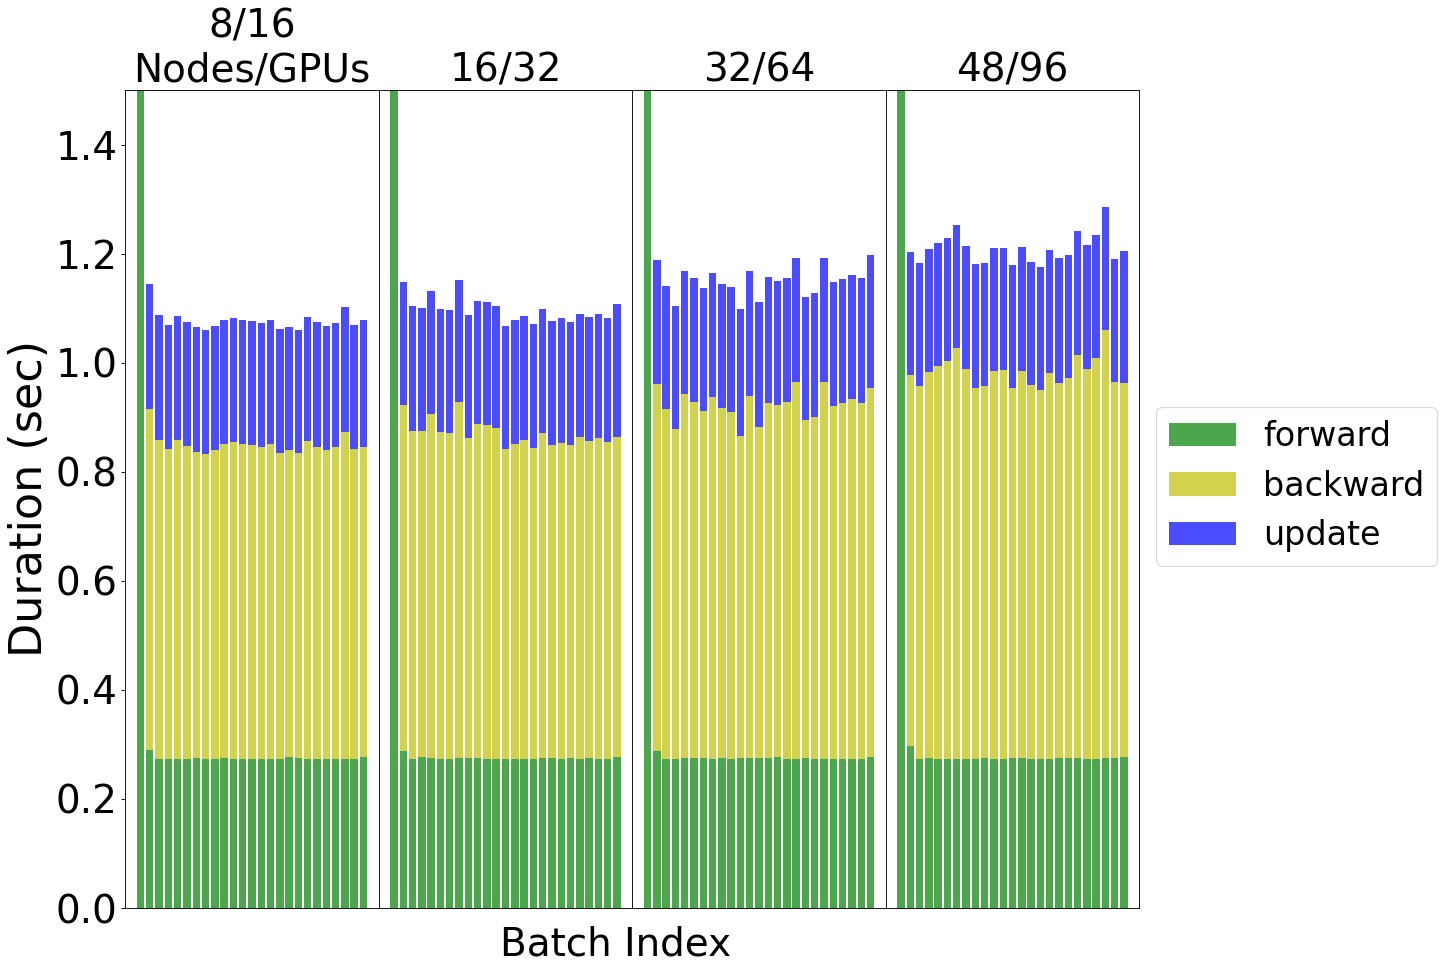

In [7]:
import matplotlib.gridspec as gridspec
from cycler import cycler

default_cycler = (cycler(color=['g', 'y', 'b']))


fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
gs1 = gridspec.GridSpec(1, 5)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 


nodes = [8, 16, 32, 48]
for i, node in enumerate(nodes):
    joins = []

    ax = plt.subplot(gs1[i])
    
    forward_length, backward_length, update_length = data[conf][i]

    ax.set_prop_cycle(default_cycler)
    ax.tick_params(axis='both', labelsize=35)

    if i == 0:
        ax.bar(range(len(forward_length)), forward_length, label='forward', alpha=0.7)
        ax.bar(range(len(backward_length)), backward_length, bottom=forward_length, label='backward', alpha=0.7)
        ax.bar(range(len(update_length)), update_length, bottom=forward_length+backward_length, label='update', alpha=0.7)
    else:
        ax.bar(range(len(forward_length)), forward_length, alpha=0.7)
        ax.bar(range(len(backward_length)), backward_length, bottom=forward_length, alpha=0.7)
        ax.bar(range(len(update_length)), update_length, bottom=forward_length+backward_length, alpha=0.7)
    
    if i == 0:
        ax.set_title(f"{node}/{node*2}\nNodes/GPUs", fontsize=35)
    else:
        ax.set_title(f"{node}/{node*2}", fontsize=35)
    ax.set_ylim(0, 1.5)
    ax.set_ylabel('Duration (sec)', fontsize=40)
    ax.set_xticks([])

    if i != 0:
        ax.set_yticks([])
        ax.set_ylabel('')
    ax.set_xlabel('')

fig.text(0.43, 0, 'Batch Index', ha='center', fontsize=35)
l = fig.legend(loc='center right',  borderaxespad=0.1, fontsize=30)
plt.tight_layout()
plt.subplots_adjust(bottom=0.05, right=0.97, wspace=0.25)